<a href="https://colab.research.google.com/github/jubair231dd/Park-Usage-Project/blob/main/ParkUsers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Loading

In [3]:
# Loading Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Loading Data

In [10]:
# Load dataset
park_data = pd.read_csv('/content/ParkUserInfo_SP.csv')
park_data.head(), park_data.shape

(        Date  Number of Park Users  Hour  Outdoor temp  Air movement  \
 0  1/12/2023                    25     0          -5.2           2.2   
 1  1/12/2023                    20     1          -5.5           0.8   
 2  1/12/2023                    17     2          -6.0           1.0   
 3  1/12/2023                    11     3          -6.2           0.9   
 4  1/12/2023                     8     4          -6.0           2.3   
 
    Condensation Temp  Solar Radiation (MJ/m2)  Precipitation(mm)  \
 0              -17.6                      0.0                0.0   
 1              -17.6                      0.0                0.0   
 2              -17.7                      0.0                0.0   
 3              -17.6                      0.0                0.0   
 4              -18.6                      0.0                0.0   
 
    Frozen Precipitation (mm)  View distance (m) Weather Phase  
 0                          0               1700             D  
 1            

In [11]:
park_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8520 entries, 0 to 8519
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8520 non-null   object 
 1   Number of Park Users       8520 non-null   int64  
 2   Hour                       8520 non-null   int64  
 3   Outdoor temp               8520 non-null   float64
 4   Air movement               8520 non-null   float64
 5   Condensation Temp          8520 non-null   float64
 6   Solar Radiation (MJ/m2)    8520 non-null   float64
 7   Precipitation(mm)          8520 non-null   float64
 8   Frozen Precipitation (mm)  8520 non-null   int64  
 9   View distance (m)          8520 non-null   int64  
 10  Weather Phase              8520 non-null   object 
dtypes: float64(5), int64(4), object(2)
memory usage: 732.3+ KB


In [12]:
park_data.describe()

,Number of Park Users,Hour,Outdoor temp,Air movement,Condensation Temp,Solar Radiation (MJ/m2),Precipitation(mm),Frozen Precipitation (mm),View distance (m)
count,8520.000000,8520.000000,8520.000000,8520.000000,8520.000000,8520.000000,8520.000000,8520.000000,8520.000000
mean,70.745188,11.500000,13.125833,1.733122,4.358052,0.576552,0.151455,0.627465,1156.976761
std,65.085033,6.922593,12.010414,1.041797,13.081113,0.875294,1.139406,3.676934,578.229606
min,0.000000,0.000000,-17.800000,0.000000,-30.600000,0.000000,0.000000,0.000000,1.000000
25%,19.000000,5.750000,3.700000,0.900000,-4.200000,0.000000,0.000000,0.000000,651.000000
50%,50.000000,11.500000,14.350000,1.500000,5.600000,0.010000,0.000000,0.000000,1405.000000
75%,107.000000,17.250000,22.700000,2.400000,15.100000,0.942500,0.000000,0.000000,1700.000000
max,356.000000,23.000000,39.400000,7.400000,27.200000,3.520000,35.000000,51.000000,1700.000000


In [13]:
#percentages of missing values in each features
park_data.isnull().sum()/len(park_data)*100

,0
Date,0.0
Number of Park Users,0.0
Hour,0.0
Outdoor temp,0.0
Air movement,0.0
Condensation Temp,0.0
Solar Radiation (MJ/m2),0.0
Precipitation(mm),0.0
Frozen Precipitation (mm),0.0
View distance (m),0.0


# Preprocessing the Data

In [14]:
# Ensuring 'Date' column is in datetime format
park_data['Date'] = pd.to_datetime(park_data['Date'], format='%d/%m/%Y', errors='coerce')

# the start and end dates for the time window
start_date = pd.Timestamp("2023-12-01")
end_date = pd.Timestamp("2024-11-20")

# Filter data
park_data = park_data[(park_data['Date'] >= start_date) & (park_data['Date'] <= end_date)]

# Extract additional features
park_data['Month'] = park_data['Date'].dt.month
park_data['Weekday'] = park_data['Date'].dt.weekday
park_data['Day Type'] = park_data['Weekday'].apply(lambda x: 'Weekend' if x in [5, 6] else 'Workday')

# One-hot encoding categorical 'Weather Phase' column
if 'Weather Phase' in park_data.columns:
    park_data = pd.get_dummies(park_data, columns=['Weather Phase'], drop_first=True)

# Display the filtered data
print(park_data.head())


        Date  Number of Park Users  Hour  Outdoor temp  Air movement  \
0 2023-12-01                    25     0          -5.2           2.2   
1 2023-12-01                    20     1          -5.5           0.8   
2 2023-12-01                    17     2          -6.0           1.0   
3 2023-12-01                    11     3          -6.2           0.9   
4 2023-12-01                     8     4          -6.0           2.3   

   Condensation Temp  Solar Radiation (MJ/m2)  Precipitation(mm)  \
0              -17.6                      0.0                0.0   
1              -17.6                      0.0                0.0   
2              -17.7                      0.0                0.0   
3              -17.6                      0.0                0.0   
4              -18.6                      0.0                0.0   

   Frozen Precipitation (mm)  View distance (m)  Month  Weekday Day Type  \
0                          0               1700     12        4  Workday   
1     

In [15]:
# Selecting features and target
features = [
    "Hour", "Outdoor temp", "Air movement", "Condensation Temp",
    "Solar Radiation (MJ/m2)", "Precipitation(mm)", "Frozen Precipitation (mm)",
    "View distance (m)", "Month", "Weekday", "Day Type"
] + [col for col in park_data.columns if col.startswith('Weather Phase_')]

target = "Number of Park Users"

# Seperating features (X) and target (y)
X = park_data[features]
y = park_data[target]

# Numerical features column
numerical_features = [
    "Hour", "Outdoor temp", "Air movement", "Condensation Temp",
    "Solar Radiation (MJ/m2)", "Precipitation(mm)", "Frozen Precipitation (mm)",
    "View distance (m)", "Month", "Weekday"
]

# Categorical features
categorical_features = ["Day Type"]

# Standardizing the numerical columns and encoding the categorical using columnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(), categorical_features)
    ],
    remainder="passthrough"  # Passes the one-hot encoded 'Weather Phase' columns
)


# Random Forest

In [16]:
# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# parameters grid for GridSearchCV to get the best parameter
param_grid = {
    "model__n_estimators": [100, 200, 300],  # min of trees
    "model__max_depth": [None, 10, 20, 30],  # min of the trees
    "model__min_samples_split": [2, 5, 10],  # min number of samples required to split
    "model__min_samples_leaf": [1, 2, 4],  # min number of samples required in a leaf node
}

# pipeline for preprocessing and model initialization
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

# GridSearchCV initialization
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_squared_error",
    cv=5,  # 5-fold cross-validation
    verbose=2,  # progress display
    n_jobs=-1  # Use all available cores
)

# Fitting GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Evaluating the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculating rmse and r2 value for rvaluating
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Random Forest (GridSearchCV) RMSE: {rmse:.4f}")
print(f"Random Forest (GridSearchCV) R²: {r2:.4f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Random Forest (GridSearchCV) RMSE: 25.2499
Random Forest (GridSearchCV) R²: 0.8538


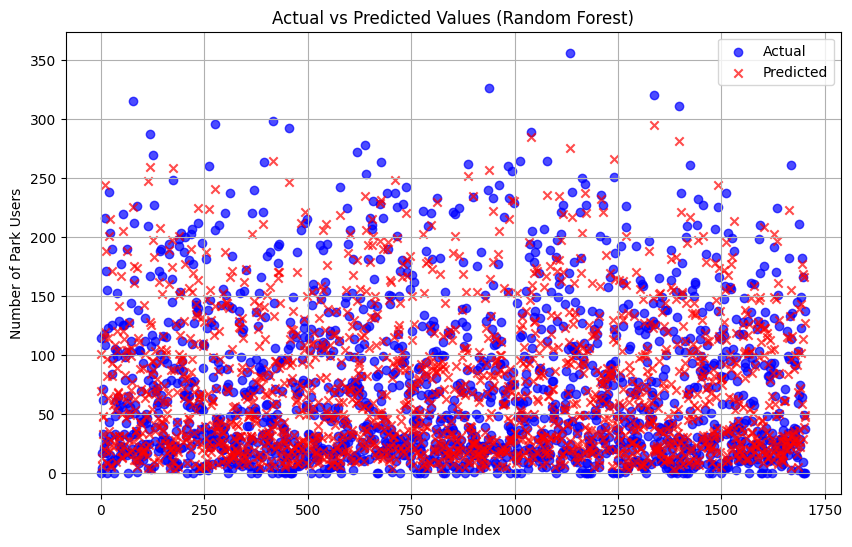

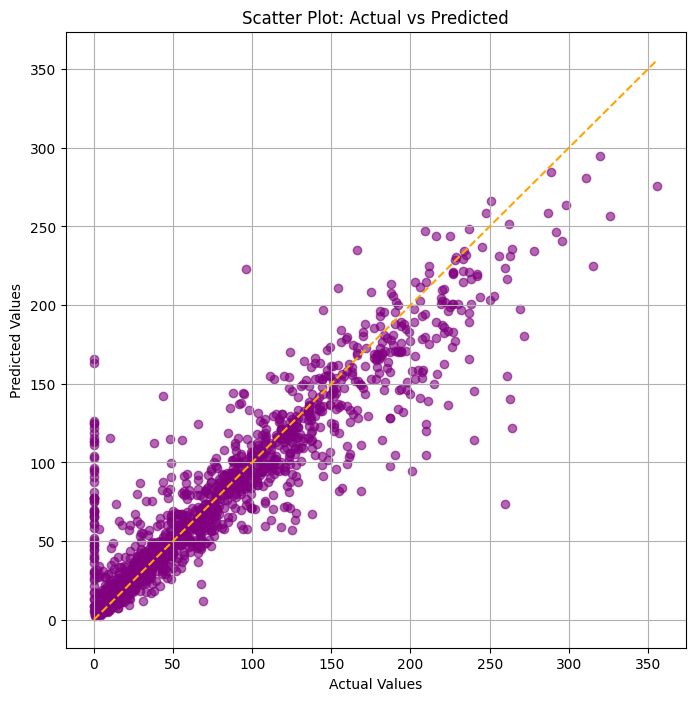

In [ ]:
# Plotting the actual vs predicted values as points
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue", marker='o', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred, label="Predicted", color="red", marker='x', alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Number of Park Users")
plt.title("Actual vs Predicted Values (Random Forest)")
plt.legend()
plt.grid()
plt.show()

# Scatter plot of predicted vs. actual
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="orange", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot: Actual vs Predicted")
plt.grid()
plt.show()


In [ ]:
# parameters grid for GridSearchCV
param_grid = {
    "model__n_estimators": [100, 200, 300],  # Number of boosting stages
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],  # Learning rate
    "model__max_depth": [3, 5, 7],  # Maximum depth of the individual estimators
    "model__min_samples_split": [2, 5, 10],  # Minimum samples to split a node
    "model__min_samples_leaf": [1, 2, 4],  # Minimum samples in a leaf node
    "model__subsample": [0.8, 1.0]  # Fraction of samples used for fitting each estimator
}

# pipeline for preprocessing and model initialization
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

# GridSearchCV initialization
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_squared_error",  # Use negative MSE as scoring metric
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Display progress
    n_jobs=-1  # Use all available cores
)

# Fitting GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Best parameters selection
print("Best Parameters:", grid_search.best_params_)

# Evaluating the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# calculating evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Gradient Boosting (GridSearchCV) RMSE: {rmse:.4f}")
print(f"Gradient Boosting (GridSearchCV) R²: {r2:.4f}")

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 300, 'model__subsample': 0.8}
Gradient Boosting (GridSearchCV) RMSE: 22.1742
Gradient Boosting (GridSearchCV) R²: 0.8873


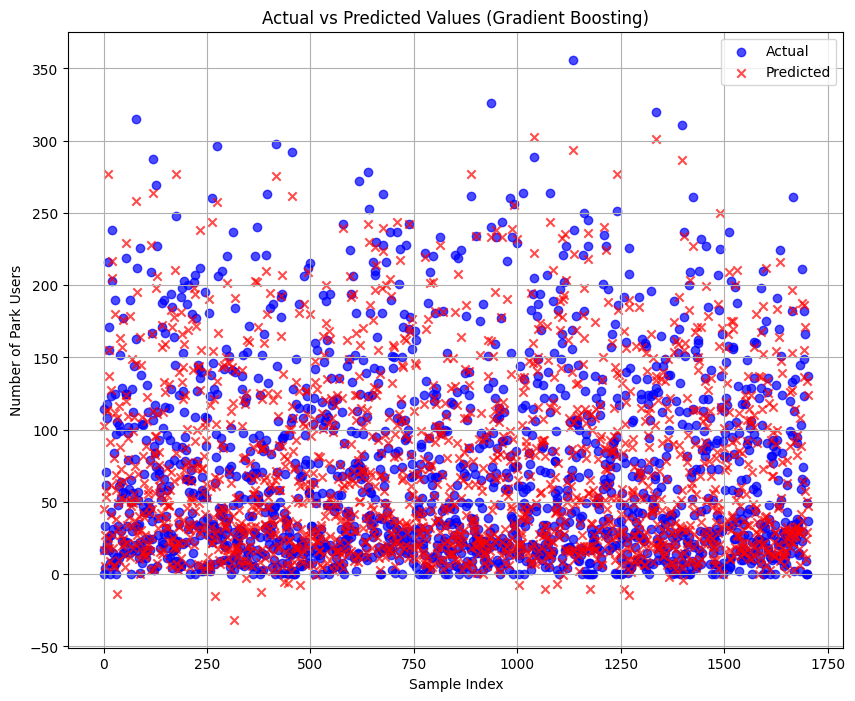

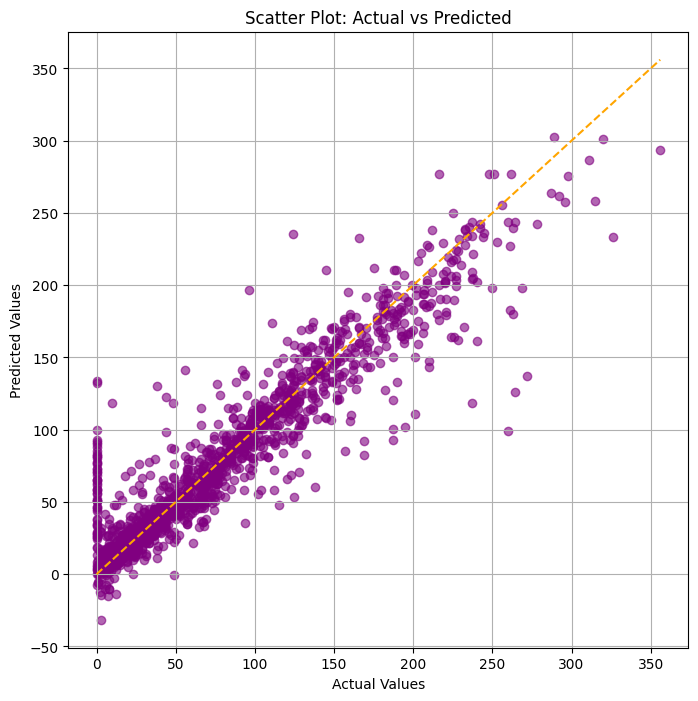

In [ ]:
# Plotting the actual vs predicted values as points
plt.figure(figsize=(10, 8))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue", marker='o', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred, label="Predicted", color="red", marker='x', alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Number of Park Users")
plt.title("Actual vs Predicted Values (Gradient Boosting)")
plt.legend()
plt.grid()
plt.show()

# Scatter plot of predicted vs. actual
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="orange", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot: Actual vs Predicted")
plt.grid()
plt.show()


In [ ]:
# selecting parameter for GridSearchCV
param_grid = {
    "model__n_estimators": [100, 200, 300],  # Number of boosting stages
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],  # Learning rate
    "model__max_depth": [3, 5, 7],  # Maximum depth of trees
    "model__min_child_weight": [1, 3, 5],  # Minimum sum of instance weights needed in a child
    "model__subsample": [0.8, 1.0],  # Fraction of samples used for training each base learner
    "model__colsample_bytree": [0.8, 1.0],  # Fraction of features used for training each tree
}

# pipeline for preprocessing and model initialization
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(random_state=42))
])

# GridSearchCV initialization
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_squared_error",  # Use negative MSE as scoring metric
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Display progress
    n_jobs=-1  # Use all available cores
)

# Fitting GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("Best Parameters:", grid_search.best_params_)

# Evaluatting the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# calculating rmse and r2 for evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"XGBoost (GridSearchCV) RMSE: {rmse:.4f}")
print(f"XGBoost (GridSearchCV) R²: {r2:.4f}")

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Parameters: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__min_child_weight': 1, 'model__n_estimators': 300, 'model__subsample': 0.8}
XGBoost (GridSearchCV) RMSE: 21.5904
XGBoost (GridSearchCV) R²: 0.8931


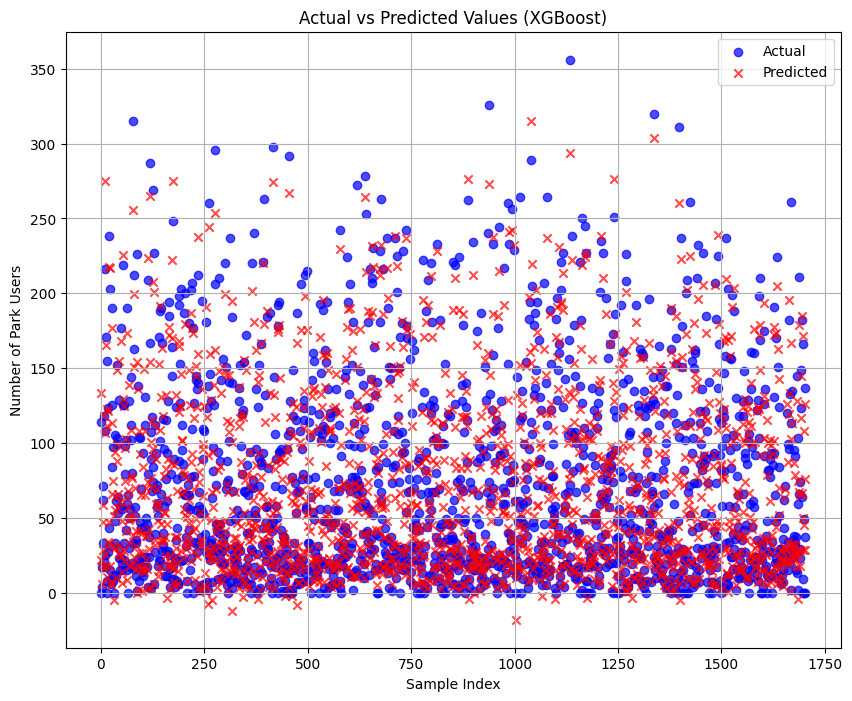

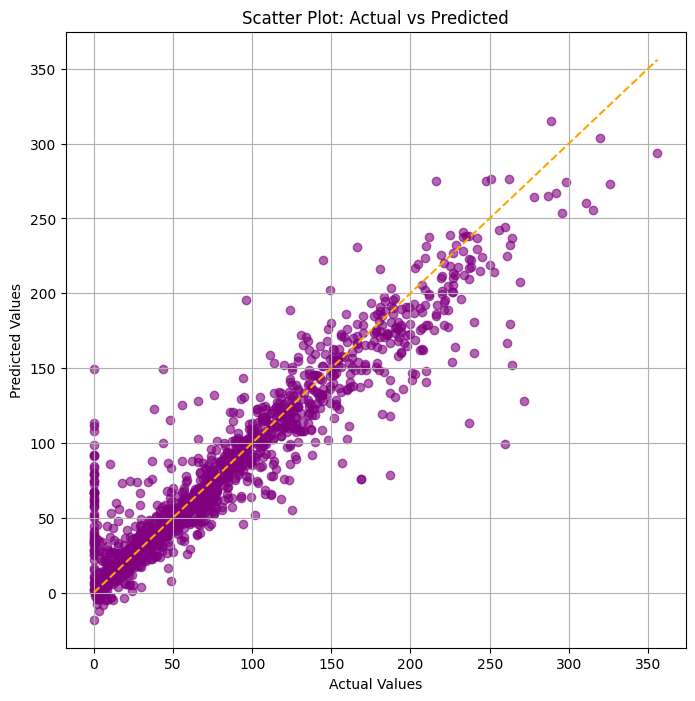

In [ ]:
# Plotting the actual vs predicted values
plt.figure(figsize=(10, 8))
plt.scatter(range(len(y_test)), y_test, label="Actual", color="blue", marker='o', alpha=0.7)
plt.scatter(range(len(y_test)), y_pred, label="Predicted", color="red", marker='x', alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Number of Park Users")
plt.title("Actual vs Predicted Values (XGBoost)")
plt.legend()
plt.grid()
plt.show()

# Scatter plot of predicted vs. actual
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="orange", linestyle="--")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot: Actual vs Predicted")
plt.grid()
plt.show()


# LSTM

Epoch 1/20, Loss: 0.0046
Epoch 2/20, Loss: 0.0127
Epoch 3/20, Loss: 0.0121
Epoch 4/20, Loss: 0.0127
Epoch 5/20, Loss: 0.0128
Epoch 6/20, Loss: 0.0030
Epoch 7/20, Loss: 0.0099
Epoch 8/20, Loss: 0.0018
Epoch 9/20, Loss: 0.0045
Epoch 10/20, Loss: 0.0016
Epoch 11/20, Loss: 0.0076
Epoch 12/20, Loss: 0.0185
Epoch 13/20, Loss: 0.0035
Epoch 14/20, Loss: 0.0129
Epoch 15/20, Loss: 0.0024
Epoch 16/20, Loss: 0.0089
Epoch 17/20, Loss: 0.0030
Epoch 18/20, Loss: 0.0161
Epoch 19/20, Loss: 0.0176
Epoch 20/20, Loss: 0.0062
LSTM RMSE: 32.9946
LSTM R²: 0.7492


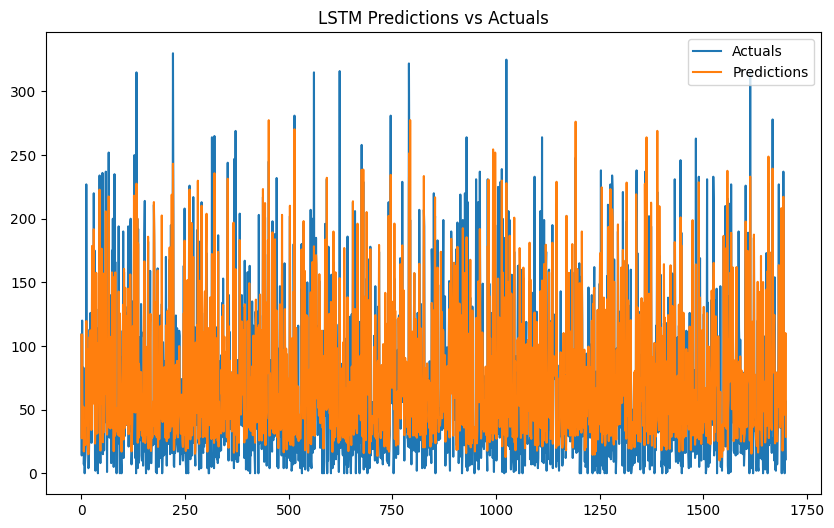

In [4]:
# Loading dataset
file_path = '/content/ParkUserInfo_SP.csv'
park_data = pd.read_csv(file_path)

# Converting 'Date' to datetime
park_data['Date'] = pd.to_datetime(park_data['Date'], format='%d/%m/%Y', errors='coerce')

# Sorting data by date and time
park_data = park_data.sort_values(by=['Date', 'Hour'])

# Extracting numerical features
features = [
    "Hour", "Outdoor temp", "Air movement", "Condensation Temp",
    "Solar Radiation (MJ/m2)", "Precipitation(mm)", "Frozen Precipitation (mm)",
    "View distance (m)"
]
target = "Number of Park Users"

# Separating scalers for features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# scaling features and target separately
features_scaled = feature_scaler.fit_transform(park_data[features])
target_scaled = target_scaler.fit_transform(park_data[[target]])

# combining scaled features and target for sequence preparation
data_scaled = np.hstack((features_scaled, target_scaled))

# Prepare data for LSTM sequences
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=24):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, index):
        x = self.data[index:index + self.sequence_length, :-1]
        y = self.data[index + self.sequence_length, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

sequence_length = 24
dataset = TimeSeriesDataset(data_scaled, sequence_length)

# Splitting into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

# Model parameters
input_size = len(features)
hidden_size = 50
num_layers = 2
output_size = 1
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    for x_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")

# Testing the model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(y_batch.tolist())

# rescaling predictions and actuals
predictions = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = target_scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# evaluating performance
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
print(f"LSTM RMSE: {rmse:.4f}")
print(f"LSTM R²: {r2:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(actuals, label="Actuals")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.title("LSTM Predictions vs Actuals")
plt.show()


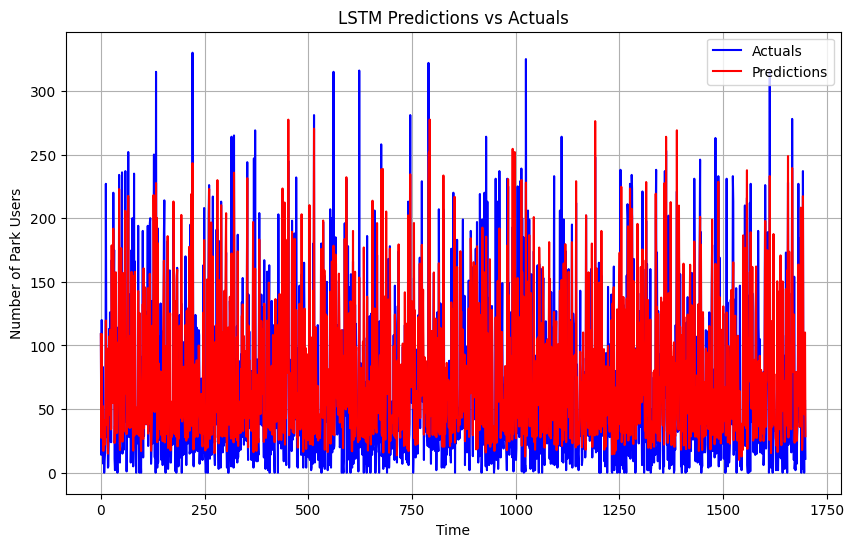

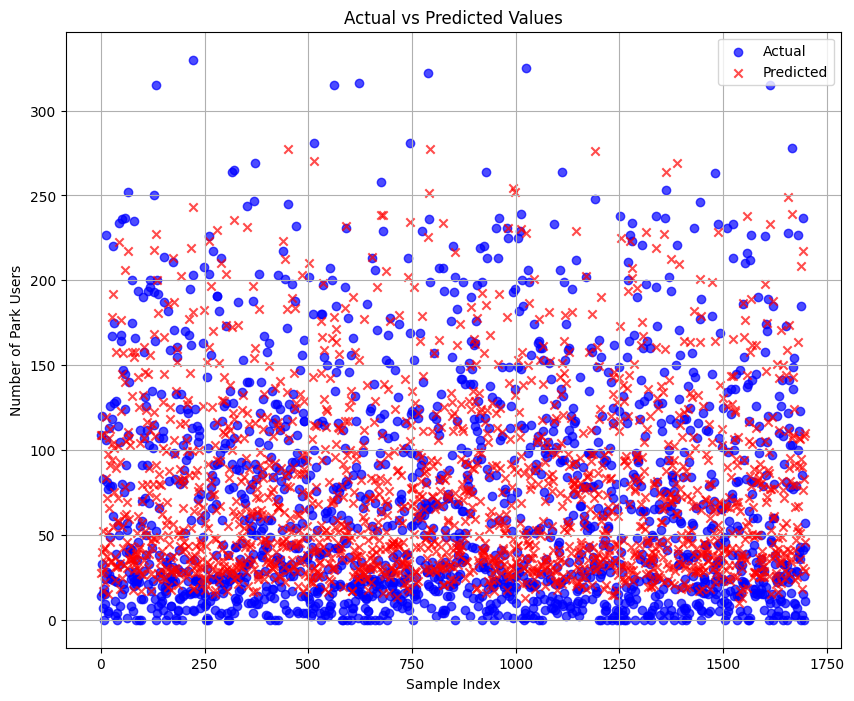

In [5]:
# Plotting the predictions vs. actuals
plt.figure(figsize=(10, 6))
plt.plot(actuals, label="Actuals", color="blue")
plt.plot(predictions, label="Predictions", color="red")
plt.legend()
plt.title("LSTM Predictions vs Actuals")
plt.xlabel("Time")
plt.ylabel("Number of Park Users")
plt.grid(True)
plt.show()

# Actual vs. Predicted Values
plt.figure(figsize=(10, 8))
plt.scatter(range(len(actuals)), actuals, label="Actual", color="blue", marker='o', alpha=0.7)
plt.scatter(range(len(predictions)), predictions, label="Predicted", color="red", marker='x', alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Number of Park Users")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid()
plt.show()

# Transformers

Epoch 1/20: 100%|██████████| 425/425 [00:29<00:00, 14.23it/s]


Epoch 1/20, Loss: 0.0585


Epoch 2/20: 100%|██████████| 425/425 [00:26<00:00, 15.87it/s]


Epoch 2/20, Loss: 0.0178


Epoch 3/20: 100%|██████████| 425/425 [00:26<00:00, 15.84it/s]


Epoch 3/20, Loss: 0.0135


Epoch 4/20: 100%|██████████| 425/425 [00:32<00:00, 12.91it/s]


Epoch 4/20, Loss: 0.0123


Epoch 5/20: 100%|██████████| 425/425 [00:26<00:00, 16.20it/s]


Epoch 5/20, Loss: 0.0118


Epoch 6/20: 100%|██████████| 425/425 [00:26<00:00, 16.26it/s]


Epoch 6/20, Loss: 0.0113


Epoch 7/20: 100%|██████████| 425/425 [00:26<00:00, 16.27it/s]


Epoch 7/20, Loss: 0.0107


Epoch 8/20: 100%|██████████| 425/425 [00:27<00:00, 15.59it/s]


Epoch 8/20, Loss: 0.0106


Epoch 9/20: 100%|██████████| 425/425 [00:25<00:00, 16.42it/s]


Epoch 9/20, Loss: 0.0102


Epoch 10/20: 100%|██████████| 425/425 [00:26<00:00, 16.27it/s]


Epoch 10/20, Loss: 0.0097


Epoch 11/20: 100%|██████████| 425/425 [00:25<00:00, 16.81it/s]


Epoch 11/20, Loss: 0.0098


Epoch 12/20: 100%|██████████| 425/425 [00:25<00:00, 16.76it/s]


Epoch 12/20, Loss: 0.0091


Epoch 13/20: 100%|██████████| 425/425 [00:26<00:00, 16.25it/s]


Epoch 13/20, Loss: 0.0106


Epoch 14/20: 100%|██████████| 425/425 [00:25<00:00, 16.45it/s]


Epoch 14/20, Loss: 0.0101


Epoch 15/20: 100%|██████████| 425/425 [00:26<00:00, 16.35it/s]


Epoch 15/20, Loss: 0.0095


Epoch 16/20: 100%|██████████| 425/425 [00:25<00:00, 16.47it/s]


Epoch 16/20, Loss: 0.0091


Epoch 17/20: 100%|██████████| 425/425 [00:25<00:00, 16.45it/s]


Epoch 17/20, Loss: 0.0089


Epoch 18/20: 100%|██████████| 425/425 [00:25<00:00, 16.46it/s]


Epoch 18/20, Loss: 0.0087


Epoch 19/20: 100%|██████████| 425/425 [00:25<00:00, 16.50it/s]


Epoch 19/20, Loss: 0.0088


Epoch 20/20: 100%|██████████| 425/425 [00:25<00:00, 16.84it/s]


Epoch 20/20, Loss: 0.0086
Transformer RMSE: 39.2778
Transformer R²: 0.6466


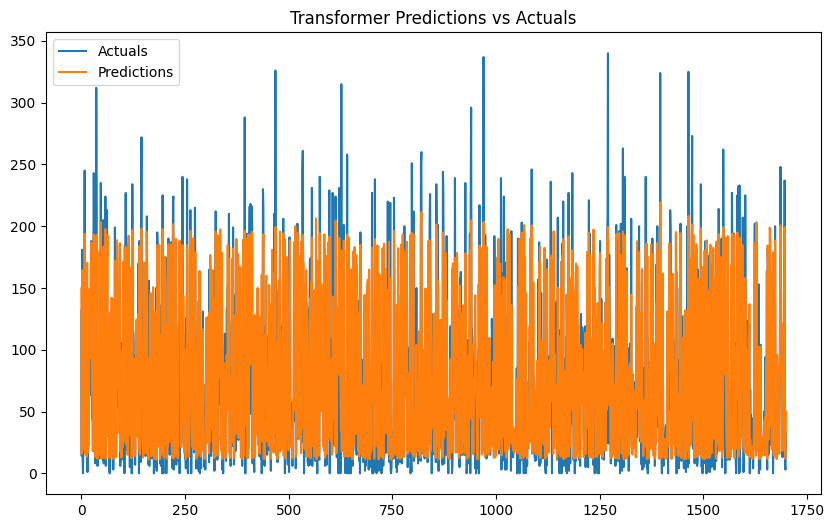

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load dataset
file_path = '/content/ParkUserInfo_SP.csv'
park_data = pd.read_csv(file_path)

# Convert 'Date' to datetime
park_data['Date'] = pd.to_datetime(park_data['Date'], format='%d/%m/%Y', errors='coerce')

# Sorting data by date and time
park_data = park_data.sort_values(by=['Date', 'Hour'])

# Extracting numerical features
features = [
    "Hour", "Outdoor temp", "Air movement", "Condensation Temp",
    "Solar Radiation (MJ/m2)", "Precipitation(mm)", "Frozen Precipitation (mm)",
    "View distance (m)"
]
target = "Number of Park Users"

# Normalizing features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(park_data[features])
target_scaled = target_scaler.fit_transform(park_data[[target]])

# Combine features and target
data_scaled = np.hstack((features_scaled, target_scaled))

# Create dataset for Transformers
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=24):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, index):
        x = self.data[index:index + self.sequence_length, :-1]
        y = self.data[index + self.sequence_length, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

sequence_length = 24
dataset = TimeSeriesDataset(data_scaled, sequence_length)

# Splitting dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, output_size, sequence_length):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(sequence_length, d_model))
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=512,
            batch_first=True
        )
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, src):
        batch_size, seq_length, input_size = src.shape
        src = self.embedding(src) + self.positional_encoding[:seq_length]
        tgt = torch.zeros_like(src).to(src.device)  # Zero tensor for prediction step
        out = self.transformer(src, tgt)
        return self.fc(out[:, -1, :])  # Output for the last time step

# Model parameters
input_size = len(features)
d_model = 64
nhead = 4
num_layers = 2
output_size = 1
model = TransformerModel(input_size, d_model, nhead, num_layers, output_size, sequence_length)

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}")

# Evaluate model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions.extend(outputs.squeeze().cpu().tolist())
        actuals.extend(y_batch.cpu().tolist())

# Rescale predictions and actuals
predictions = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = target_scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Evaluate performance
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)
print(f"Transformer RMSE: {rmse:.4f}")
print(f"Transformer R²: {r2:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(actuals, label="Actuals")
plt.plot(predictions, label="Predictions")
plt.legend()
plt.title("Transformer Predictions vs Actuals")
plt.show()


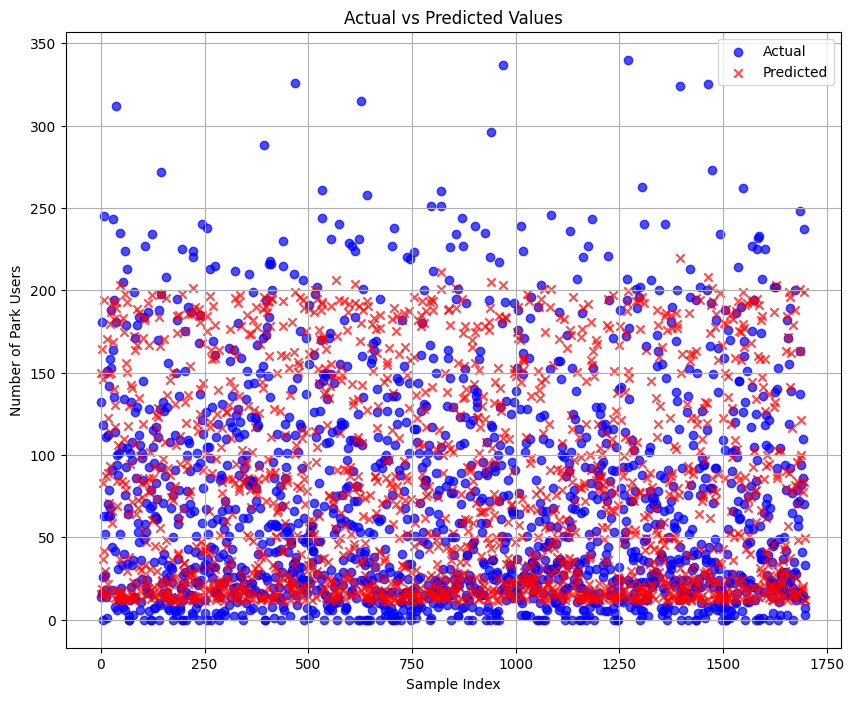

In [7]:
# Actual vs. Predicted Values
plt.figure(figsize=(10, 8))
plt.scatter(range(len(actuals)), actuals, label="Actual", color="blue", marker='o', alpha=0.7)
plt.scatter(range(len(predictions)), predictions, label="Predicted", color="red", marker='x', alpha=0.7)
plt.xlabel("Sample Index")
plt.ylabel("Number of Park Users")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.grid()
plt.show()